In [2]:
import sys

sys.path.append("/home/Spencer/code/probcal")

In [5]:
from probcal.evaluation.calibration_evaluator import CalibrationResults
from probcal.models import GaussianNN
from probcal.data_modules import COCOPeopleDataModule
from properscoring import crps_gaussian
from probcal.models.backbones import ViT

import torch
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

In [7]:
dm = COCOPeopleDataModule("../data/coco-people", batch_size=256, num_workers=20, persistent_workers=True)
dm.prepare_data()
dm.setup("")

seitzer_results = CalibrationResults.load("../results/coco-people/seitzer/calibration_results.pt")

seitzer = GaussianNN(backbone_type=ViT, backbone_kwargs={"output_dim": 64})
seitzer.load_state_dict(torch.load("../chkp/coco-people/seitzer/version_0/best_loss.pt", weights_only=True))

<All keys matched successfully>

In [8]:
device = torch.device("cuda")

seitzer = seitzer.to(device)

In [9]:
# 1. Compute pointwise metrics on test set.

nll_vals = {"seitzer": [], "stirn": []}
crps_vals = {"seitzer": [], "stirn": []}
mae_vals = {"seitzer": [], "stirn": []}
var_vals = {"seitzer": [], "stirn": []}

with torch.inference_mode():
    for images, labels in dm.test_dataloader():
        images, labels = images.to(device), labels.to(device)

        for name, model in zip(("seitzer",), (seitzer,)):
            pred = model.predict(images)
            pred_dist = model.predictive_dist(pred)
            var = pred_dist.variance.detach().cpu()
            var_vals[name].append(var)
            mae_vals[name].append((labels.flatten() - pred_dist.mean.flatten()).abs().detach().cpu())
            crps_vals[name].append(
                crps_gaussian(
                    labels.flatten().detach().cpu(),
                    pred_dist.mean.flatten().detach().cpu(),
                    pred_dist.variance.sqrt().flatten().detach().cpu(),
                )
            )
            nll_vals[name].append(
                -pred_dist.log_prob(labels.flatten()).detach().cpu()
            )

ValueError: need at least one array to concatenate

In [20]:
for metrics_dict in nll_vals, mae_vals, crps_vals, var_vals:
    for k in metrics_dict:
        if metrics_dict[k]:
            metrics_dict[k] = np.concatenate(metrics_dict[k])

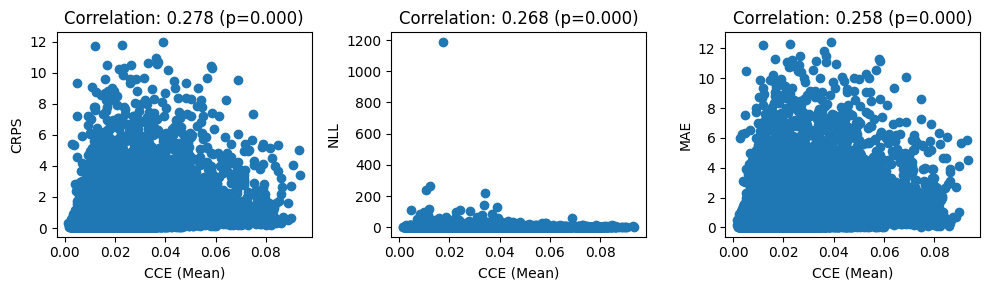

In [24]:
fig, axs = plt.subplots(1, 3, figsize=(10, 3))
for j, (metrics_dict, metric_name) in enumerate(zip((crps_vals, nll_vals, mae_vals), ("CRPS", "NLL", "MAE"))):
    for i, (calib_results, name) in enumerate(zip((seitzer_results,), ("seitzer",))):
        x = calib_results.cce.expected_values
        y = metrics_dict[name]
        axs[j].scatter(x, y)
        axs[j].set_xlabel("CCE (Mean)")
        axs[j].set_ylabel(metric_name)
        correlation = stats.kendalltau(x, y)
        axs[j].set_title(f"Correlation: {correlation.statistic:.3f} (p={correlation.pvalue:.3f})")
fig.tight_layout()
plt.show()

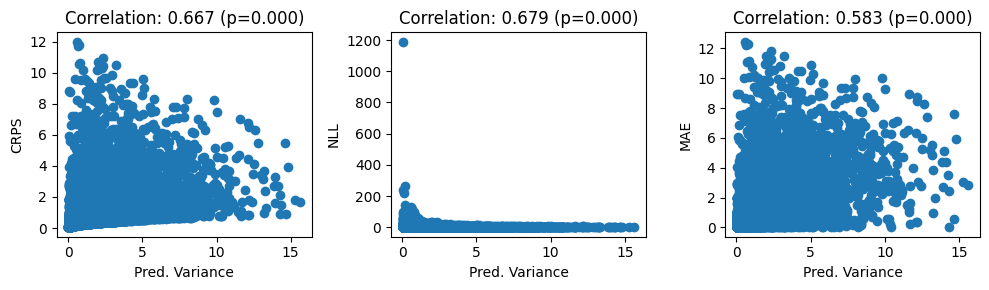

In [25]:
fig, axs = plt.subplots(1, 3, figsize=(10, 3))
for j, (metrics_dict, metric_name) in enumerate(zip((crps_vals, nll_vals, mae_vals), ("CRPS", "NLL", "MAE"))):
    for i, (calib_results, name) in enumerate(zip((seitzer_results,), ("seitzer",))):
        x = var_vals[name]
        y = metrics_dict[name]
        axs[j].scatter(x, y)
        axs[j].set_xlabel("Pred. Variance")
        axs[j].set_ylabel(metric_name)
        correlation = stats.kendalltau(x, y)
        axs[j].set_title(f"Correlation: {correlation.statistic:.3f} (p={correlation.pvalue:.3f})")
fig.tight_layout()
plt.show()

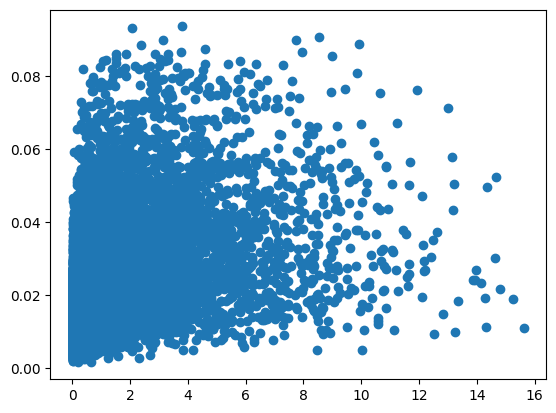

In [28]:
plt.scatter(var_vals["seitzer"], seitzer_results.cce.expected_values)